## First Level Analysis

In [1]:
from nilearn import plotting
%matplotlib inline
import os
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
from nipype.interfaces import spm
from nipype.interfaces import fsl
from nipype.interfaces import matlab as mlab
from nipype.interfaces.base import Bunch

In [2]:
spm.SPMCommand.set_mlab_paths(paths=os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')), matlab_cmd='/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB -nodesktop -nosplash')

stty: 'standard input': Inappropriate ioctl for device


In [3]:
mlab.MatlabCommand.set_default_matlab_cmd("/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB  -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths(os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')))

In [4]:
fsl.FSLCommand.set_default_output_type('NIFTI')

In [5]:
base_dir = os.path.join(os.environ['HOME'], 'spmbasics/data/')

In [6]:
data_dir = os.path.join(base_dir, 'MoAEpilot/task-auditory_bold.json')

In [7]:
experiment_dir = os.path.join(base_dir, 'output')
output_dir = 'nipype'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['01']
task_id = ['auditory']

# TR of functional images
with open(os.path.join(base_dir, 'MoAEpilot/task-auditory_bold.json'), 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Smoothing width used during preprocessing
fwhm = [6]

In [8]:
subjectinfo = [
    Bunch(
        conditions=['Task'], onsets=[list(range(6, 84, 12))], durations=[[6]])
]

In [9]:
cont1 = ('listening > rest', 'T', ['Task'], [1])
contrasts = [cont1]

In [10]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='scans',
                                 output_units='scans',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128,
                                 subject_info = subjectinfo),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix same as the first level tutorial
FirstLeveldesign = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='scans',
                                 interscan_interval=TR,
                                 volterra_expansion_order=1,
                                 flags={'mthresh': 0.8},
                                 global_intensity_normalization='none',
                                 microtime_onset=8,
                                 microtime_resolution=16,
                                 model_serial_correlations='AR(1)'),
                    name="FirstLeveldesign")

# EstimateModel - estimate the parameters of the model
FirstLevelestimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      write_residuals=True, 
                      name="FirstLevelestimate")

# EstimateContrast - estimates contrasts
FirstLevelconest = Node(EstimateContrast(), name="FirstLevelconest")

In [11]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'contrasts'],
                                    contrasts=contrasts),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': os.path.join(output_dir, 'preprocess', '_subject_id_{subject_id}_task_name_{task_id}',
                         'swarsub-{subject_id}_task-{task_id}_bold.nii'),
             'rptxt': os.path.join(output_dir, 'preprocess', '_subject_id_{subject_id}_task_name_{task_id}', 
                             'rp_sub-{subject_id}_task-{task_id}_bold.txt')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'auditory'

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

In [12]:
# Initiation of the 1st-level analysis workflow
FirstLevel = Workflow(name='FirstLevel')
FirstLevel.base_dir = os.path.join(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
FirstLevel.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                    (infosource, FirstLevelconest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('rptxt', 'realignment_parameters')]),
                    (modelspec, FirstLeveldesign, [('session_info','session_info')]),
                    (FirstLeveldesign, FirstLevelestimate, [('spm_mat_file','spm_mat_file')]),
                    (FirstLevelestimate, FirstLevelconest, [('spm_mat_file','spm_mat_file'),
                                                            ('beta_images','beta_images'),
                                                            ('residual_image','residual_image')]),
                    (FirstLevelestimate, datasink, [('mask_image','FirstLevel.@mask_image'),
                                                    ('beta_images','FirstLevel.@beta_images'),
                                                    ('residual_images','FirstLevel.@residual_images'),
                                                    ('residual_image','FirstLevel.@residual_image'),
                                                    ('RPVimage', 'FirstLevel.@RPVimage')
                                               ]),
                    (FirstLevelconest, datasink, [('spm_mat_file', 'FirstLevel.@spm_mat'),
                                                  ('spmT_images', 'FirstLevel.@T'),
                                                  ('con_images', 'FirstLevel.@con'),
                                                  ('ess_images', 'FirstLevel.@ess'),
                                              ]),
    
                    ])

240527-19:05:24,560 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/OLD/output/workingdir/FirstLevel/colored_l1analysis.png (graph2use=colored, simple_form=True).


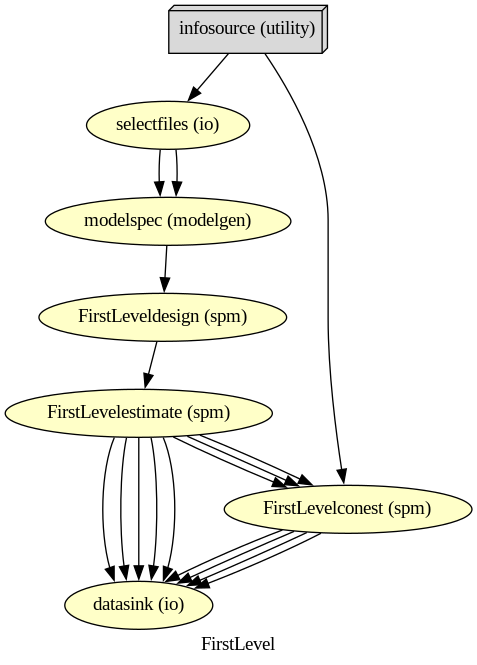

In [13]:
# Create 1st-level analysis output graph
FirstLevel.write_graph(graph2use='colored', format='png', dotfilename='colored_l1analysis.dot', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(FirstLevel.base_dir, 'FirstLevel', 'colored_l1analysis.png'))

In [14]:
FirstLevel.write_graph(graph2use='flat', format='png', dotfilename='flat_l1analysis.dot', simple_form=True)

240527-19:05:24,837 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/OLD/output/workingdir/FirstLevel/flat_l1analysis.png (graph2use=flat, simple_form=True).


'/home/matay/spmbasics/data/OLD/output/workingdir/FirstLevel/flat_l1analysis.png'

In [15]:
FirstLevel.run('MultiProc', plugin_args={'n_procs': 4})

240527-19:05:24,849 nipype.workflow INFO:
	 Workflow FirstLevel settings: ['check', 'execution', 'logging', 'monitoring']
240527-19:05:24,856 nipype.workflow INFO:
	 Running in parallel.
240527-19:05:24,859 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240527-19:05:24,947 nipype.workflow INFO:
	 [Node] Setting-up "FirstLevel.selectfiles" in "/home/matay/spmbasics/data/OLD/output/workingdir/FirstLevel/_subject_id_01/selectfiles".
240527-19:05:24,952 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
240527-19:05:24,954 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.000789s.
240527-19:05:26,864 nipype.workflow INFO:
	 [Job 0] Completed (FirstLevel.selectfiles).
240527-19:05:26,870 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240527-19:05:26,942 nipype.workflow INFO:
	 [Nod

stty: 'standard input': Inappropriate ioctl for device


240527-19:05:46,940 nipype.workflow INFO:
	 [Node] Finished "FirstLeveldesign", elapsed time 11.199197999999999s.


stty: 'standard input': Inappropriate ioctl for device


240527-19:05:48,883 nipype.workflow INFO:
	 [Job 2] Completed (FirstLevel.FirstLeveldesign).
240527-19:05:48,887 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240527-19:05:48,956 nipype.workflow INFO:
	 [Node] Setting-up "FirstLevel.FirstLevelestimate" in "/home/matay/spmbasics/data/OLD/output/workingdir/FirstLevel/_subject_id_01/FirstLevelestimate".
240527-19:05:48,963 nipype.workflow INFO:
	 [Node] Executing "FirstLevelestimate" <nipype.interfaces.spm.model.EstimateModel>
240527-19:05:50,885 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.57/13.77, Free processors: 3/4.
                     Currently running:
                       * FirstLevel.FirstLevelestimate


stty: 'standard input': Inappropriate ioctl for device


240527-19:06:11,56 nipype.workflow INFO:
	 [Node] Finished "FirstLevelestimate", elapsed time 15.383967s.


stty: 'standard input': Inappropriate ioctl for device


240527-19:06:12,907 nipype.workflow INFO:
	 [Job 3] Completed (FirstLevel.FirstLevelestimate).
240527-19:06:12,911 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240527-19:06:12,979 nipype.workflow INFO:
	 [Node] Setting-up "FirstLevel.FirstLevelconest" in "/home/matay/spmbasics/data/OLD/output/workingdir/FirstLevel/_subject_id_01/FirstLevelconest".
240527-19:06:12,990 nipype.workflow INFO:
	 [Node] Executing "FirstLevelconest" <nipype.interfaces.spm.model.EstimateContrast>
240527-19:06:14,909 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.57/13.77, Free processors: 3/4.
                     Currently running:
                       * FirstLevel.FirstLevelconest


stty: 'standard input': Inappropriate ioctl for device


240527-19:06:29,641 nipype.workflow INFO:
	 [Node] Finished "FirstLevelconest", elapsed time 10.063525s.


stty: 'standard input': Inappropriate ioctl for device


240527-19:06:30,925 nipype.workflow INFO:
	 [Job 4] Completed (FirstLevel.FirstLevelconest).
240527-19:06:30,927 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240527-19:06:30,998 nipype.workflow INFO:
	 [Node] Setting-up "FirstLevel.datasink" in "/home/matay/spmbasics/data/OLD/output/workingdir/FirstLevel/_subject_id_01/datasink".
240527-19:06:31,4 nipype.workflow INFO:
	 [Node] Executing "datasink" <nipype.interfaces.io.DataSink>
240527-19:06:31,6 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.001047s.
240527-19:06:32,927 nipype.workflow INFO:
	 [Job 5] Completed (FirstLevel.datasink).
240527-19:06:32,932 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.


In [17]:
!tree ./spmbasics/data/output/datasink/FirstLevel

/home/matay/spmbasics/data/output/datasink/FirstLevel
└── _subject_id_01
    ├── beta_0001.nii
    ├── beta_0002.nii
    ├── beta_0003.nii
    ├── beta_0004.nii
    ├── beta_0005.nii
    ├── beta_0006.nii
    ├── beta_0007.nii
    ├── beta_0008.nii
    ├── con_0001.nii
    ├── mask.nii
    ├── ResMS.nii
    ├── RPV.nii
    ├── SPM.mat
    └── spmT_0001.nii

2 directories, 14 files


In [18]:
from nilearn.plotting import plot_stat_map
anatimg = './spmbasics/data/MoAEpilot/sub-01/anat/sub-01_T1w.nii'

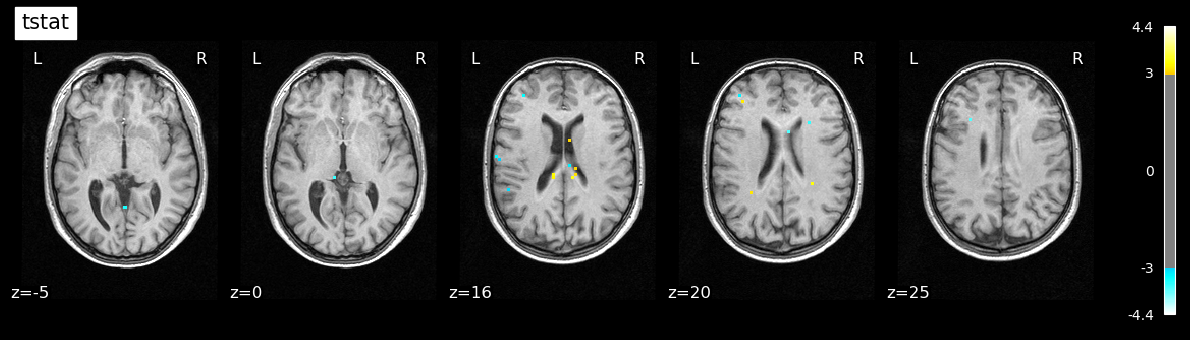

In [21]:
plot_stat_map(
    './spmbasics/data/output/datasink/1stLevel/_subject_id_01/spmT_0001.nii', title='tstat',
    bg_img=anatimg, threshold=3, display_mode='z', cut_coords=(-5, 0, 16, 20, 25), dim=-1);

/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:1317: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


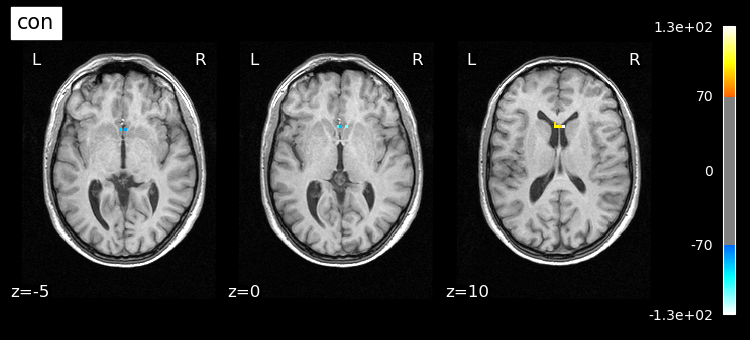

In [43]:
plot_stat_map(
    './spmbasics/data/output/datasink/1stLevel/_subject_id_01/con_0001.nii', title='con',
    bg_img=anatimg, threshold=70, display_mode='z', cut_coords=(-5, 0, 10), dim=-1);